## Testing and development of the background bar interpolation function

In [190]:
import sys
sys.path.append('/home/jls/work/nsd_edf/')
sys.path.append('/home/jls/work/nsd/Gerhard/')
sys.path.append('/home/jls/work/nsd/AGAMA/')
from read_Portail import Portail
from kde import KDE_fft_ND
from scipy.interpolate import RegularGridInterpolator
import agama
import numpy as np


class Portail_interp(Portail):
    """
    Class for interpolating KDE estimates for the phase-space density of the Portail+ N-body model

    Args:
        lrange (list): range of longitudes to interpolate over
        brange (float): range of latitudes to interpolate over
        N (int): number of points to interpolate over
        radius (float): radius to use for KDE
        include_vlos (bool): whether to include the line-of-sight velocity in the KDE
        shift_sgrA (np.array): shift to apply to the coordinates to put Sgr A* at the origin
        gc_dist (float): distance to the Galactic centre

    We work in a coordinate system shifted by (lshift, bshift). The density distribution is approximately
    symmetric about this centre so we only need to cover half of the b-space. This means all input coordinates
    are shifted.
    """
    def __init__(self, 
                 lrange_degree = [-1.5,1.5], 
                 brange_degree = 1.5,
                 N=20, 
                 radius_degree=0.1, 
                 include_vlos=False, 
                 shift_sgrA=np.deg2rad(np.array([0., -0.05576432, -0.04616002]))*8.275, 
                 gc_dist=8.275):
        
        super(Portail_interp, self).__init__()
        self.cut_stuff()
        self.symmetrise()
        self.realign()


        lrange = np.deg2rad(lrange_degree)
        brange = np.deg2rad(brange_degree)
        radius = np.deg2rad(radius_degree)

        self.lbr=np.array(agama.getGalacticFromGalactocentric(self.y+shift_sgrA[0],-self.x+shift_sgrA[1],self.z+shift_sgrA[2],
                                                     100.*self.vy,-100.*self.vx,100.*self.vz, galcen_distance=gc_dist)).T
        
        self.lshift = shift_sgrA[1]/gc_dist
        self.bshift = shift_sgrA[2]/gc_dist

        self.lrange, self.brange = np.linspace(lrange[0], lrange[1], N) - self.lshift, np.linspace(0., brange + np.abs(self.bshift), N)
        self.lbgrid = np.meshgrid(self.lrange, self.brange, indexing='ij')

        fltr_fn = lambda ll,bb: np.hypot((self.lbr[:,0]-self.lshift-ll)*np.cos(bb),
                                          self.lbr[:,1]-self.bshift-bb)<radius

        self.pft = [KDE_fft_ND(self.lbr[fltr_fn(ll,bb),3:5+include_vlos], 
                               weights=self.m[fltr_fn(ll,bb)], bw_scale=0.5)
                               for ll,bb in zip(self.lbgrid[0].flatten(),self.lbgrid[1].flatten())]
        
        self.dens = np.reshape([np.sum(self.m[fltr_fn(ll,bb)]) / radius**2 / np.cos(bb) / np.pi
                     for ll,bb in zip(self.lbgrid[0].flatten(),self.lbgrid[1].flatten())], 
                     self.lbgrid[0].shape)


    def find_bracket_indices(self, sorted_array, values):
        lower_indices = np.searchsorted(sorted_array, values, side='left')
        lower_indices[lower_indices == 0] += 1
        return lower_indices-1

    def evaluate(self, Lcoords, Bcoords, Vcoords, include_density=True, return_density=False):
        '''
        Evaluate the density at a given point in (l,b,v) space

        Args:
            Lcoords (float): longitude in degrees
            Bcoords (float): latitude in degrees
            Vcoords (float): proper motion in km/s/kpc
            include_density (bool): whether to include the density in the KDE estimate
            return_density (bool): whether to return the density as well as the KDE estimate
        
        Returns:
            float: KDE estimate at the given point
        '''

        Lcoords = np.deg2rad(Lcoords - 360.*(Lcoords>180.)) - self.lshift
        Bcoords = np.deg2rad(Bcoords) - self.bshift
            
        gg=np.reshape([self.pft[i](Vcoords) for i in range(len(self.pft))], 
                      (*self.lbgrid[0].shape,len(Vcoords)))
        ll = self.find_bracket_indices(self.lrange, Lcoords)
        bb = self.find_bracket_indices(self.brange, np.abs(Bcoords))
        delta_l = (Lcoords - self.lrange[ll])/(self.lrange[ll+1]-self.lrange[ll])
        delta_b = (np.abs(Bcoords) - self.brange[bb])/(self.brange[bb+1]-self.brange[bb])
        ar = np.arange(len(Vcoords))

        if include_density:
            inT = gg[ll,bb,ar]*self.dens[ll,bb]*(1-delta_l)*(1-delta_b) + \
                gg[ll+1,bb,ar]*self.dens[ll+1,bb]*delta_l*(1-delta_b) + \
                gg[ll,bb+1,ar]*self.dens[ll,bb+1]*(1-delta_l)*delta_b + \
                gg[ll+1,bb+1,ar]*self.dens[ll+1,bb+1]*delta_l*delta_b
        else:
            inT = gg[ll,bb,ar]*(1-delta_l)*(1-delta_b) + \
                gg[ll+1,bb,ar]*delta_l*(1-delta_b) + \
                gg[ll,bb+1,ar]*(1-delta_l)*delta_b + \
                gg[ll+1,bb+1,ar]*delta_l*delta_b
            
        if return_density:
            return inT, self.dens[ll,bb]*(1-delta_l)*(1-delta_b) + \
                self.dens[ll+1,bb]*delta_l*(1-delta_b) + \
                self.dens[ll,bb+1]*(1-delta_l)*delta_b + \
                self.dens[ll+1,bb+1]*delta_l*delta_b

        return inT


    def density(self, Lcoords, Bcoords):
        '''
        Evaluate the density at a given point in (l,b) space

        Args:
            Lcoords (float): longitude in degrees
            Bcoords (float): latitude in degrees
        
        Returns:
            float: KDE estimate at the given point
        '''

        Lcoords = np.deg2rad(Lcoords - 360.*(Lcoords>180.)) - self.lshift
        Bcoords = np.deg2rad(Bcoords) - self.bshift
            
        ll = self.find_bracket_indices(self.lrange, Lcoords)
        bb = self.find_bracket_indices(self.brange, np.abs(Bcoords))
        delta_l = (Lcoords - self.lrange[ll])/(self.lrange[ll+1]-self.lrange[ll])
        delta_b = (np.abs(Bcoords) - self.brange[bb])/(self.brange[bb+1]-self.brange[bb])

        return self.dens[ll,bb]*(1-delta_l)*(1-delta_b) + \
            self.dens[ll+1,bb]*delta_l*(1-delta_b) + \
            self.dens[ll,bb+1]*(1-delta_l)*delta_b + \
            self.dens[ll+1,bb+1]*delta_l*delta_b


pp = Portail_interp(N=20, include_vlos=False)

reading Portail bar...
Omegap=37.5 km/s/kpc


0.7105263157894737 0.6862315684210527


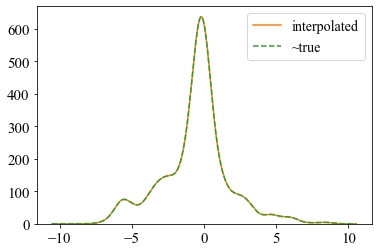

In [197]:
## Test

import matplotlib.pyplot as plt
from kde import KDE_fft

Lcentre = pp.lbgrid[0][14,0] + pp.lshift + 0.*np.deg2rad(0.125/2.)
Bcentre = pp.lbgrid[1][0,9] + pp.bshift  + 0.*np.deg2rad(0.125/2.)

Lcoords = np.ones(10000)*Lcentre
Bcoords = np.ones(10000)*Bcentre

fltr_fn = np.hypot((pp.lbr[:,0]-Lcentre)*np.cos(Bcentre),
                    pp.lbr[:,1]-Bcentre)<np.deg2rad(0.1)
pp_test = KDE_fft_ND(pp.lbr[fltr_fn,3:5], 
                     weights=pp.m[fltr_fn], bw_scale=0.5)
density = np.sum(pp.m[fltr_fn]) / np.deg2rad(0.1)**2 / np.cos(Bcentre) / np.pi

further_fltr = np.abs(pp.lbr[:,3]+7.*4.74)<0.5*4.74
plt.hist(pp.lbr[fltr_fn&further_fltr,4]/4.74, bins=100, 
         density=True, histtype='step',weights=pp.m[fltr_fn&further_fltr])

print(np.rad2deg(Lcentre), np.rad2deg(Bcentre))

xx = np.linspace(-50,50,10000)
Vcoords = np.vstack([-7.*np.ones(len(Lcoords))*4.74,xx]).T
inT = pp.evaluate(np.rad2deg(Lcoords), np.rad2deg(Bcoords), Vcoords)

plt.plot(xx/4.74,inT*600.,label='interpolated')
plt.plot(xx/4.74,pp_test(Vcoords)*600.*density,label='~true',ls='dashed')

plt.legend()

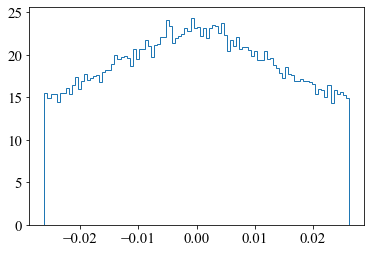

In [200]:
plt.hist(pp.lbr[:,1][np.abs(pp.lbr[:,0])<np.deg2rad(1.5)],weights=pp.m[np.abs(pp.lbr[:,0])<np.deg2rad(1.5)],
         bins=100,density=True,histtype='step',range=np.deg2rad(np.linspace(-1.5,1.5,2)));

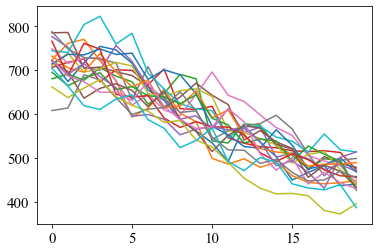

In [206]:
plt.plot(pp.dens.T);

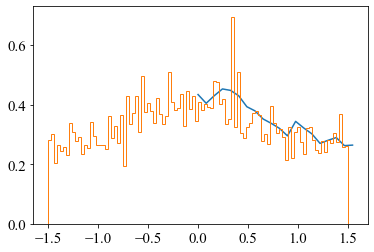

In [231]:
Brange = np.linspace(-1.5,1.5,100)
# plt.plot(Brange,pp.density(np.ones_like(Brange)*0.,Brange))
# plt.ylim(0.,1000.)
plt.plot(np.rad2deg(pp.brange),6e-4*pp.dens.T[:,0]);
plt.hist(180./np.pi*pp.lbr[:,1][np.abs(pp.lbr[:,0])<np.deg2rad(0.05)],
         weights=pp.m[np.abs(pp.lbr[:,0])<np.deg2rad(0.05)],range=[-1.5,1.5],bins=100,density=True,histtype='step');

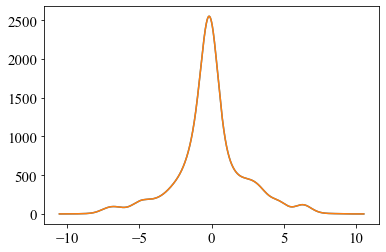

In [186]:
inT = pp.evaluate(np.rad2deg(Lcoords), np.rad2deg(Bcoords), Vcoords)
plt.plot(xx/4.74,inT*600.,label='interpolated')
inT = pp.evaluate(np.rad2deg(Lcoords), np.rad2deg(-Bcoords+2*pp.bshift), Vcoords)
plt.plot(xx/4.74,inT*600.,label='interpolated')

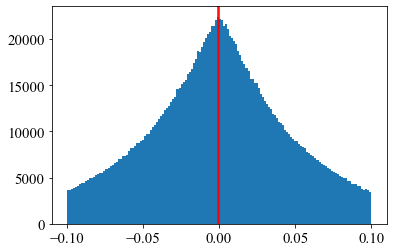

In [173]:
plt.hist(pp.lbr[:,1][np.abs(pp.lbr[:,0])<0.1],bins=150,range=[-0.1,0.1]);
plt.axvline(np.deg2rad(np.array([0., -0.05576432, -0.04616002]))[1], color='r')
plt.axvline(0., color='r')

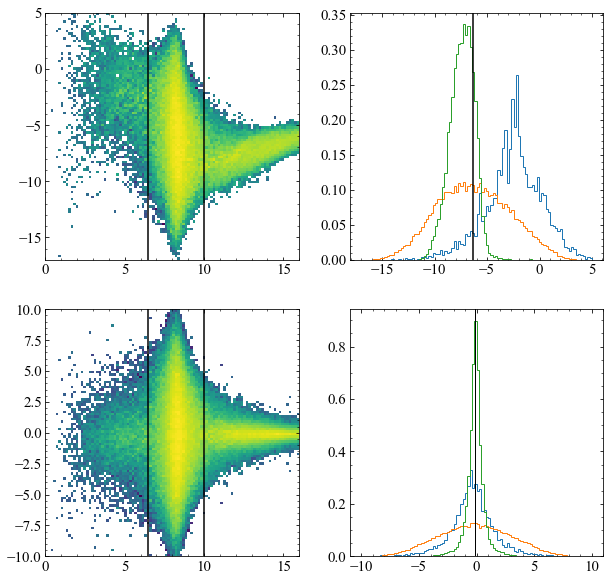

In [268]:
f,a=plt.subplots(2,2,figsize=[10,10])

from plotting_general import add_inner_ticks

plt.sca(a[0][0])
fltr = np.abs(pp.lbr[:,0])<np.deg2rad(1.5)
fltr &= np.abs(pp.lbr[:,1])<np.deg2rad(1.5)
plt.hist2d(pp.lbr[fltr,2], pp.lbr[fltr,3]/4.74, bins=100, range=[[0.,16.],[-17,5.]], weights=pp.m[fltr], norm=LogNorm());
plt.axvline(6.5,color='k')
plt.axvline(10.,color='k')
add_inner_ticks()

plt.sca(a[0][1])
efltr = fltr&(pp.lbr[:,2]<6.5)
plt.hist(pp.lbr[efltr,3]/4.74, bins=100, range=[-17,5.], weights=pp.m[efltr], histtype='step', density=True);
efltr = fltr&(pp.lbr[:,2]>6.5)&(pp.lbr[:,2]<10.)
plt.hist(pp.lbr[efltr,3]/4.74, bins=100, range=[-17,5.], weights=pp.m[efltr], histtype='step', density=True);
efltr = fltr&(pp.lbr[:,2]>10.)
plt.hist(pp.lbr[efltr,3]/4.74, bins=100, range=[-17,5.], weights=pp.m[efltr], histtype='step', density=True);
plt.axvline(-6.379,color='k')
add_inner_ticks()

plt.sca(a[1][0])
plt.hist2d(pp.lbr[fltr,2], pp.lbr[fltr,4]/4.74, bins=100, range=[[0.,16.],[-10,10.]], weights=pp.m[fltr], norm=LogNorm());
plt.axvline(6.5,color='k')
plt.axvline(10.,color='k')
add_inner_ticks()

plt.sca(a[1][1])
efltr = fltr&(pp.lbr[:,2]<6.5)
plt.hist(pp.lbr[efltr,4]/4.74, bins=100, range=[-10,10.], weights=pp.m[efltr], histtype='step', density=True);
efltr = fltr&(pp.lbr[:,2]>6.5)&(pp.lbr[:,2]<10.)
plt.hist(pp.lbr[efltr,4]/4.74, bins=100, range=[-10,10.], weights=pp.m[efltr], histtype='step', density=True);
efltr = fltr&(pp.lbr[:,2]>10.)
plt.hist(pp.lbr[efltr,4]/4.74, bins=100, range=[-10,10.], weights=pp.m[efltr], histtype='step', density=True);
plt.axvline(-7.25/4.74/8.275, color='k',lw=1)
add_inner_ticks()

In [38]:
import pandas as pd
data_tmp = pd.read_csv('final_nsd_mira_full_cols.csv')

In [64]:
Lcentre = pp.lbgrid[0][20,0] + pp.lshift + 0.001
Bcentre = pp.lbgrid[1][0,10] + pp.bshift
print(np.rad2deg(Lcentre),np.rad2deg(Bcentre))

fltr_fn = np.hypot((pp.lbr[:,0]-Lcentre)*np.cos(Bcentre),
                    pp.lbr[:,1]-Bcentre)<0.001047*2

1.147447049774729 0.43130480927568604


In [70]:
from selection_function import *
S = selection_function()

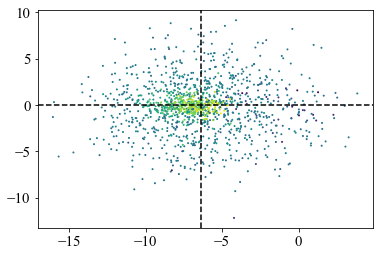

In [69]:
plt.scatter(pp.lbr[fltr_fn,3]/4.74+np.random.normal(0,0.5,np.count_nonzero(fltr_fn)), 
            pp.lbr[fltr_fn,4]/4.74+np.random.normal(0,0.5,np.count_nonzero(fltr_fn)), c=pp.lbr[fltr_fn,2], s=1, cmap='viridis')
plt.axvline(-6.379, c='k', ls='--')
plt.axhline(0., c='k', ls='--')

In [82]:
np.rad2deg(Lcentre),np.rad2deg(Bcentre)

(1.147447049774729, 0.43130480927568604)

-0.28494743805232914 -0.04616002


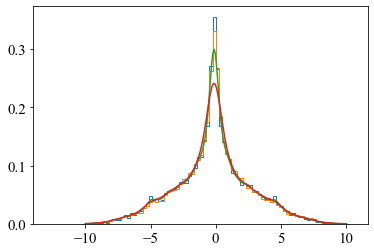

In [4]:
from kde import KDE_fft
import matplotlib.pyplot as plt

Lcentre = pp.lbgrid[0][10,0] + pp.lshift + 0.001
Bcentre = pp.lbgrid[1][0,0] + pp.bshift
print(np.rad2deg(Lcentre),np.rad2deg(Bcentre))

fltr_fn = np.hypot((pp.lbr[:,0]-Lcentre)*np.cos(Bcentre),
                    pp.lbr[:,1]-Bcentre)<0.001047*10

xx = np.linspace(-10,10,1000)
pp_test = KDE_fft(pp.lbr[fltr_fn,4]/4.74, weights=pp.m[fltr_fn], gridsize=256, bw_scale=0.5)#*S.Snorm(np.rad2deg(Lcentre),np.rad2deg(Bcentre),pp.lbr[fltr_fn,2],100.))
plt.hist(pp.lbr[fltr_fn,4]/4.74, bins=100, density=True, histtype='step',
         weights=pp.m[fltr_fn])
plt.hist(pp.lbr[fltr_fn,4]/4.74, bins=100, density=True, histtype='step')
plt.plot(xx,pp_test(xx))


pp_test = KDE_fft(pp.lbr[fltr_fn,4]/4.74, weights=pp.m[fltr_fn], gridsize=256, bw_scale=1.0)#*S.Snorm(np.rad2deg(Lcentre),np.rad2deg(Bcentre),pp.lbr[fltr_fn,2],100.))
plt.plot(xx,pp_test(xx))
# plt.xlim(-10,10)
# plt.axvline(-6.379)

1.147447049774729 0.43130480927568604
318


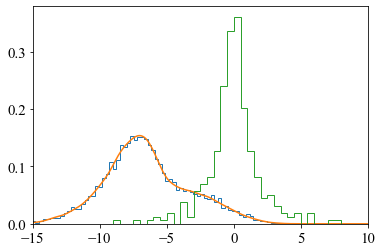

In [64]:
Lcentre = pp.lbgrid[0][20,0] + pp.lshift + 0.001
Bcentre = pp.lbgrid[1][0,10] + pp.bshift
print(np.rad2deg(Lcentre),np.rad2deg(Bcentre))

fltr_fn = np.hypot((pp.lbr[:,0]-Lcentre)*np.cos(Bcentre),
                    pp.lbr[:,1]-Bcentre)<0.001047*10

xx = np.linspace(-400,400,1000)

pp_test = KDE_fft(pp.lbr[fltr_fn,3]/4.74, weights=pp.m[fltr_fn], gridsize=256)
plt.hist(pp.lbr[fltr_fn,3]/4.74+np.random.normal(0.,0.5,size=np.count_nonzero(fltr_fn)), bins=100, density=True, histtype='step',weights=pp.m[fltr_fn])
plt.plot(xx/8.2,pp_test(xx/8.2),label='with s')

plt.xlim(-15,10)

fltr = (np.abs(data_tmp['b'])>0.0)&(data_tmp['period']>400.)&(data_tmp['period']<500.)
print(np.count_nonzero(fltr))
plt.hist(data_tmp['pml'][fltr],range=[-15,10],bins=50,histtype='step',density=True);
# # plot gaussian width 20 km/s
# plt.plot(xx/8.2,3./np.sqrt(2*np.pi*(20.)**2)*np.exp(-xx**2/(2*(20.)**2)),label='gaussian')

1.147447049774729 0.43130480927568604
139


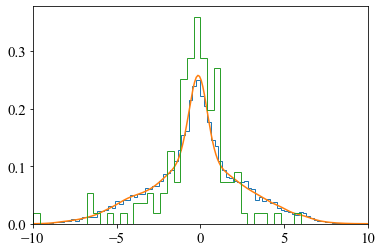

In [65]:
Lcentre = pp.lbgrid[0][20,0] + pp.lshift + 0.001
Bcentre = pp.lbgrid[1][0,10] + pp.bshift
print(np.rad2deg(Lcentre),np.rad2deg(Bcentre))

fltr_fn = np.hypot((pp.lbr[:,0]-Lcentre)*np.cos(Bcentre),
                    pp.lbr[:,1]-Bcentre)<0.001047*10

xx = np.linspace(-400,400,1000)

# pp_test = KDE_fft(pp.lbr[fltr_fn,4]*8.3, weights=pp.m[fltr_fn])
# plt.hist(pp.lbr[fltr_fn,4]*8.3, bins=100, density=True, histtype='step',weights=pp.m[fltr_fn])
# plt.plot(xx,pp_test(xx),label='all')

# pp_test = KDE_fft(pp.lbr[fltr_fn,4]*pp.lbr[fltr_fn,2], weights=pp.m[fltr_fn])
# plt.hist(pp.lbr[fltr_fn,4]*pp.lbr[fltr_fn,2], bins=100, density=True, histtype='step',weights=pp.m[fltr_fn])
# plt.plot(xx,pp_test(xx),label='with s')
# plt.legend()

pp_test = KDE_fft(pp.lbr[fltr_fn,4]/4.74, weights=pp.m[fltr_fn], gridsize=256)
plt.hist(pp.lbr[fltr_fn,4]/4.74+np.random.normal(0.,0.5,size=np.count_nonzero(fltr_fn)), bins=100, density=True, histtype='step',weights=pp.m[fltr_fn])
plt.plot(xx/8.2,pp_test(xx/8.2),label='with s')

plt.xlim(-10,10)

fltr = (np.abs(data_tmp['b'])<0.2)&(data_tmp['period']>500.)&(data_tmp['period']<600.)
print(np.count_nonzero(fltr))
plt.hist(data_tmp['pmb'][fltr],range=[-10,10],bins=50,histtype='step',density=True);
# # plot gaussian width 20 km/s
# plt.plot(xx/8.2,3./np.sqrt(2*np.pi*(20.)**2)*np.exp(-xx**2/(2*(20.)**2)),label='gaussian')

32405
0.4000000000000006 0.0 -0.028999999999999998 0.0 0 0 -0.03 0.0
2.6572978690543163 133.7252828685555


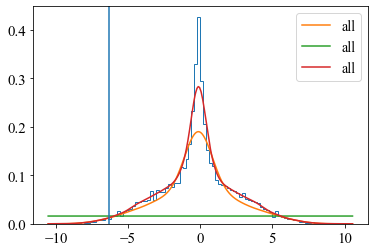

In [24]:
import matplotlib.pyplot as plt
from kde import KDE_fft

Lcentre = pp.lbgrid[0][0,0] + pp.lshift + 0.001
Bcentre = pp.lbgrid[1][0,0] + pp.bshift

Lcoords = np.ones(10000)*Lcentre - pp.lshift
Bcoords = np.ones(10000)*Bcentre - pp.bshift

fltr_fn = np.hypot((pp.lbr[:,0]-Lcentre)*np.cos(Bcentre),
                    pp.lbr[:,1]-Bcentre)<0.001047*10
print(np.count_nonzero(fltr_fn))
pp_test = KDE_fft(pp.lbr[fltr_fn,4], weights=pp.m[fltr_fn], gridsize=256)
plt.hist(pp.lbr[fltr_fn,4]/4.74, bins=100, density=True, histtype='step',weights=pp.m[fltr_fn])

# print(Lcoords[0], Bcoords[0],pp.lrange, pp.brange)

xx = np.linspace(-50,50,10000)
Vcoords = np.vstack([-6.*np.ones(len(Lcoords))*4.74,xx]).T

def find_bracket_indices(sorted_array, values):
    lower_indices = np.searchsorted(sorted_array, values, side='left')
    lower_indices[lower_indices == 0] += 1
    return lower_indices-1
    
gg=np.reshape([pp.pft[i](Vcoords) for i in range(len(pp.pft))], (*pp.lbgrid[0].shape,len(Vcoords)))
ll = find_bracket_indices(pp.lrange, Lcoords)
bb = find_bracket_indices(pp.brange, np.abs(Bcoords))
delta_l = (Lcoords - pp.lrange[ll])/(pp.lrange[ll+1]-pp.lrange[ll])
delta_b = (np.abs(Bcoords) - pp.brange[bb])/(pp.brange[bb+1]-pp.brange[bb])
ar = np.arange(len(Vcoords))
print(delta_l[0], delta_b[0], Lcoords[0], Bcoords[0], ll[0], bb[0], pp.lrange[ll[0]], pp.brange[bb[0]])

inT = gg[ll,bb,ar]*(1-delta_l)*(1-delta_b) + gg[ll+1,bb,ar]*delta_l*(1-delta_b) + gg[ll,bb+1,ar]*(1-delta_l)*delta_b + gg[ll+1,bb+1,ar]*delta_l*delta_b

# plt.plot(xx/4.74,pFields.fields[fld_no]['kde'](np.vstack([xx,np.zeros_like(xx)]).T),label='fld')

plt.plot(xx/4.74,inT*150.,label='all')
print(np.sum(inT), np.sum(pp_test(Vcoords)))
plt.plot(xx/4.74,pp_test(Vcoords)*4.74,label='all')

plt.legend()
plt.axvline(-6.3)

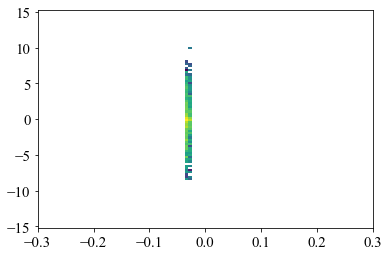

In [92]:
from matplotlib.colors import LogNorm
plt.hist2d(pp.lbr[fltr_fn,0],pp.lbr[fltr_fn,4]/4.74,bins=100,weights=pp.m[fltr_fn], 
           range=[[-0.3,0.3],[-15.2,15.2]], norm=LogNorm());

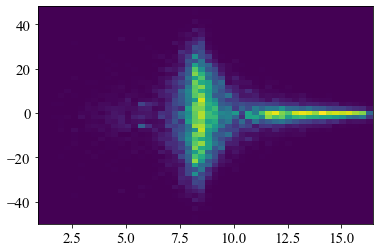

In [37]:
plt.hist2d(pp.lbr[fltr_fn,2],pp.lbr[fltr_fn,4],bins=50,weights=pp.m[fltr_fn]);

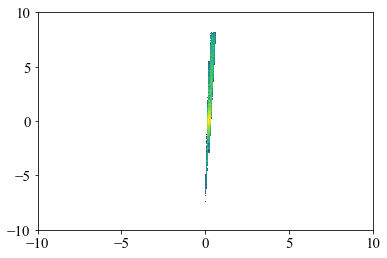

In [29]:
from matplotlib.colors import LogNorm
plt.hist2d(pp.x[fltr_fn],pp.y[fltr_fn],bins=300,weights=pp.m[fltr_fn], 
           range=[[-10,10],[-10,10]], norm=LogNorm());